In [2]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 600)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import spacy
import random
from gensim import models, corpora, similarities
from wordcloud import WordCloud

d:\MY APPS\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Load data into list D:\2324Sem2\BT4222\Project\Potential Dataset\spotify_millsongdata.csv
file_path = r'D:/2324Sem2/BT4222/Project/GitRepo/RecommendationSystem/KnowledgeGraph/Lyrics/Unique_Song_Eng_Lyrics.xslx'

# Use pandas to read the CSV file
#df = pd.read_csv(file_path)

songs_df = pd.read_excel('Unique_Song_Eng_Lyrics.xlsx')
data = list(songs_df['lyrics'])

# Print length and example
print("Number of songs:", len(data))
print("\nFirst song:", data[0])

Number of songs: 288253

First song: 
alarmed for the condition in which the kingdom was likely to be involved by the kings death an endeavor to prevent the consequences which were but too plainly foreseen was productive of the most serious and fatal effects the king in his long and lingering affliction was induced to make a will by which he bequeathed the english crown to lady jane the daughter of the duke of suffolk who had been married to lord guilford the son of the duke of northumberland and was the granddaughter of the second sister of king henry by charles duke of suffolk by this will the succession of mary and elizabeth his two sisters was entirely superseded from an apprehension of the returning system of popery and the kings council with the chief of the nobility the lordmayor of the city of london and almost all the judges and the principal lawyers of the realm subscribed their names to this regulation as a sanction to the measure lord chief justice hale though a true protes

In [4]:
# Clean text
clean_data = [str(i).replace('\n','').replace('\r','') for i in data]

In [5]:
#Load English language model
nlp = spacy.load("en_core_web_sm")

# Disable named-entity recognition and parsing to save time
unwanted_pipes = ["ner", "parser"]

# Custom tokenizer using spacy
def custom_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in nlp(doc) if t.is_alpha and not t.is_space and not t.is_punct and not t.is_stop and t.pos_ in ["ADJ","NOUN","VERB"]]

In [6]:
%%time

# Tokenize data
tokenized_data = list(map(custom_tokenizer, nlp.pipe(clean_data, n_process=4)))

# Print example
print(tokenized_data[0])

['alarm', 'condition', 'kingdom', 'likely', 'involve', 'king', 'death', 'endeavor', 'prevent', 'consequence', 'foresee', 'productive', 'fatal', 'effect', 'king', 'long', 'linger', 'affliction', 'induce', 'bequeath', 'english', 'crown', 'daughter', 'duke', 'suffolk', 'marry', 'son', 'duke', 'northumberland', 'granddaughter', 'second', 'sister', 'king', 'suffolk', 'succession', 'sister', 'supersede', 'apprehension', 'return', 'system', 'popery', 'king', 'council', 'chief', 'nobility', 'lordmayor', 'city', 'judge', 'principal', 'lawyer', 'realm', 'subscribe', 'name', 'regulation', 'sanction', 'measure', 'hale', 'true', 'protestant', 'upright', 'judge', 'decline', 'unite', 'favor', 'lady', 'jane', 'signify', 'opinion', 'entitle', 'assume', 'rein', 'government', 'object', 'mary', 'place', 'throne', 'account', 'fear', 'marry', 'foreigner', 'bring', 'crown', 'considerable', 'danger', 'partiality', 'popery', 'leave', 'little', 'doubt', 'mind', 'induce', 'revive', 'dormant', 'interest', 'pope',

In [19]:
# Save Tokenized data
import pickle

# Assuming `tokenized_data` is your list of tokenized documents
with open('tokenized_data.pkl', 'wb') as file:
    pickle.dump(tokenized_data, file)

print("Tokenized data has been saved locally.")

Tokenized data has been saved locally.


In [20]:
import pickle
with open('tokenized_data.pkl', 'rb') as file:
    tokenized_data = pickle.load(file)

print("Tokenized data has been loaded.")
print(tokenized_data[0])  # Example to print first document's tokens

Tokenized data has been loaded.
['alarm', 'condition', 'kingdom', 'likely', 'involve', 'king', 'death', 'endeavor', 'prevent', 'consequence', 'foresee', 'productive', 'fatal', 'effect', 'king', 'long', 'linger', 'affliction', 'induce', 'bequeath', 'english', 'crown', 'daughter', 'duke', 'suffolk', 'marry', 'son', 'duke', 'northumberland', 'granddaughter', 'second', 'sister', 'king', 'suffolk', 'succession', 'sister', 'supersede', 'apprehension', 'return', 'system', 'popery', 'king', 'council', 'chief', 'nobility', 'lordmayor', 'city', 'judge', 'principal', 'lawyer', 'realm', 'subscribe', 'name', 'regulation', 'sanction', 'measure', 'hale', 'true', 'protestant', 'upright', 'judge', 'decline', 'unite', 'favor', 'lady', 'jane', 'signify', 'opinion', 'entitle', 'assume', 'rein', 'government', 'object', 'mary', 'place', 'throne', 'account', 'fear', 'marry', 'foreigner', 'bring', 'crown', 'considerable', 'danger', 'partiality', 'popery', 'leave', 'little', 'doubt', 'mind', 'induce', 'revive'

In [21]:
# Build dictionary of (token, ID) mappings
dct = corpora.Dictionary(tokenized_data)

# Print vocab size
print('Size of vocabulary before filtering:', len(dct))

# Filter overly low and high frequency tokens
dct.filter_extremes(no_below=5, no_above=0.5)

# Print vocab size
print('\nSize of vocabulary after filtering:', len(dct))

# Example mappings
print("\nExample mappings:", [(i,dct.token2id[i]) for i in tokenized_data[0][:10]])

Size of vocabulary before filtering: 2042240

Size of vocabulary after filtering: 100000

Example mappings: [('alarm', 30), ('condition', 189), ('kingdom', 495), ('likely', 530), ('involve', 483), ('king', 494), ('death', 235), ('endeavor', 289), ('prevent', 694), ('consequence', 197)]


In [23]:
# Bag-of-Words sparse matrix
bow = [dct.doc2bow(i) for i in tokenized_data]

In [24]:
%%time

# Train LDA model
lda_model = models.LdaModel(corpus=bow, num_topics=10, passes=10, alpha='auto', eta='auto', id2word=dct, random_state=0)

Wall time: 1h 38min 12s


In [31]:
# Print generated topics
lda_model.print_topics()

[(0,
  '0.086*"feat" + 0.016*"lil" + 0.010*"love" + 0.006*"young" + 0.006*"rich" + 0.005*"kid" + 0.005*"remix" + 0.004*"big" + 0.004*"time" + 0.004*"girl"'),
 (1,
  '0.017*"say" + 0.013*"look" + 0.009*"go" + 0.007*"s" + 0.006*"think" + 0.006*"come" + 0.006*"door" + 0.005*"time" + 0.005*"take" + 0.005*"know"'),
 (2,
  '0.027*"know" + 0.023*"love" + 0.018*"feel" + 0.016*"want" + 0.015*"go" + 0.014*"come" + 0.012*"m" + 0.012*"time" + 0.012*"like" + 0.011*"let"'),
 (3,
  '0.006*"people" + 0.005*"time" + 0.004*"new" + 0.004*"work" + 0.004*"year" + 0.004*"state" + 0.004*"world" + 0.003*"act" + 0.003*"great" + 0.003*"law"'),
 (4,
  '0.010*"man" + 0.009*"say" + 0.007*"come" + 0.006*"day" + 0.005*"know" + 0.005*"king" + 0.005*"time" + 0.005*"great" + 0.004*"see" + 0.004*"hand"'),
 (5,
  '0.009*"hand" + 0.007*"bloom" + 0.005*"watch" + 0.005*"eye" + 0.004*"old" + 0.004*"go" + 0.004*"look" + 0.004*"breen" + 0.004*"good" + 0.004*"s"'),
 (6,
  '0.032*"get" + 0.027*"m" + 0.017*"know" + 0.016*"s" + 0.

In [26]:
print(lda_model.alpha) # Document-topic prior
print(lda_model.eta) # Topic-word prior (beta)

[0.01782604 0.10998115 0.6057088  0.05590187 0.11429662 0.03611068
 0.25609    0.03558498 0.05151712 0.01316891]
[0.09825247 0.06627424 0.17435184 ... 0.06086067 0.06086614 0.0608508 ]


In [32]:
# Get topics
topics = list(lda_model.get_document_topics(bow, minimum_probability=0))

# Print topic proportion in corpus
for i in range(10):
    print(f"Topic {i} proportion: {100*sum([pair[i][1] for pair in topics])/len(topics):.1f}%")

Topic 0 proportion: 1.5%
Topic 1 proportion: 6.8%
Topic 2 proportion: 49.9%
Topic 3 proportion: 4.1%
Topic 4 proportion: 9.7%
Topic 5 proportion: 1.6%
Topic 6 proportion: 19.7%
Topic 7 proportion: 1.6%
Topic 8 proportion: 4.3%
Topic 9 proportion: 0.6%


In [28]:
# Return top topics in a song
def get_top_topics(song_idx, min_prob):

    # Sort topics from highest to lowest frequency
    topics = sorted(lda_model.get_document_topics(bow[song_idx], minimum_probability=min_prob), key=lambda tup: tup[1])[::-1]

    # Get word distribution for each topic
    pairs = [lda_model.show_topic(pair[0]) for pair in topics]
    topic_words = [[pair[0] for pair in topic] for topic in pairs]

    return pd.DataFrame({'Major Topics': topics,'Topic Words': topic_words})

In [29]:
# Example
display(get_top_topics(100, 0.25))
print(data[100][:300])

,Major Topics,Topic Words
0,"(2, 0.92334414)","[know, love, feel, want, go, come, m, time, like, let]"


how i couldnt wait to make my escape
in the back of a passenger
give it all youve got
for all that you want
ive been on that hunt

 
all i know is i wanna wake up next to god

 
im feeling cynical
it all feels so subliminal
every word you said starts dancing in my head
so back up on the carousel
thi


In [30]:
# Coherence score (closer to 0 the better)
coherence_model = models.coherencemodel.CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dct, coherence='u_mass')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score:.4f}')

KeyboardInterrupt: 

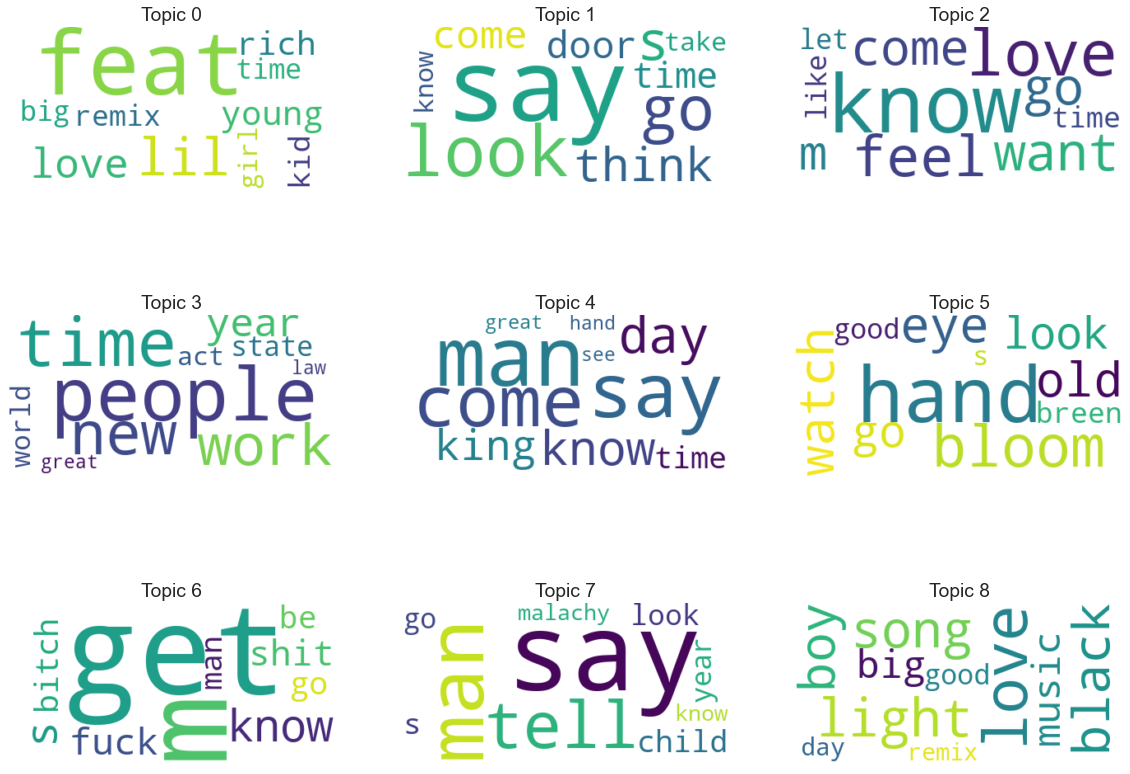

In [ ]:
# Plot word clouds for each topic
word_cloud = WordCloud(background_color='white', max_words=10)
fig, axes = plt.subplots(3, 3, figsize=(20,15))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(lda_model.show_topic(i))
    word_cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(word_cloud, interpolation='bilinear')
    plt.gca().set_title(f'Topic {i}')
    plt.gca().axis('off')
plt.show()